# Obesity Modelado

**Variable objetivo:** Obesity: 
- **0** -> Riesgo nulo o bajo
- **1** -> Riesgo medio
- **2** -> Riesgo alto

Se trata de un problema de clasificación supervisada. 

1. Primero evaluaré los modelos regresión logística, árboles de decisión, vector support machines y ramdon forest; utilizando los datos origianles del dataset (no los calculados).
2. Escogeré los dos mejores modelos para compararlos con diferentes subconjuntos de datos.
3. Seleccionaré el modelo definitivo.
4. Construiré 2 workflows:

- Workflow para entrenar el modelo con todos los datos y guardarlo
- Workflow para hacer la predicción para una persona

**Tareas:**

1. Cargar los datos
2. Selección y separación del dataset
3. Transformación de los datos (si necesario)
4. Entrenar y evaluar diferentes modelos de clasificación
5. Escoger el(los) mejor(es) modelo(s)
6. Ajustar y mejorar el modelo escogido
7. Contruir los workflows



In [1]:
# Librerías
from pathlib import Path
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Dividir el dataframe
from sklearn.model_selection import train_test_split

# Clasificación supervisada
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Armando pipelines
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline

# Funciones propias
import data_common_functions as dcf
import char_common_functions as ccf
from custom_functions import custom_calculus

## Tareas generales

### Cargar los datos

In [2]:
# Leemos el archivo
CURRENT_DIR = Path.cwd()

BASE_DIR = Path(CURRENT_DIR).parent

df_obesity = dcf.read_file(f"{BASE_DIR}/data/out/obesity_labeled.parquet")

df_obesity

,age,age_range,gender,height,weight,waist_circum_preferred,hip_circum,gender_bin,bmi,rcc,...,obesity_bmi_txt,obesity_cc,obesity_cc_txt,obesity_rcc,obesity_rcc_txt,obesity_ict,obesity_ict_txt,risk_factors,cluster,obesity
1,47.0,46-55,male,187.1980,156.630,138.5062,142.1892,1,44.696399,0.974098,...,3-Obesidad,1,1-Alto,1,1-Medio,3,3-Obesidad,4,3,2
2,50.0,46-55,male,180.5940,98.064,98.3996,109.9058,1,30.067891,0.895309,...,3-Obesidad,1,1-Alto,0,0-Bajo,2,2-Sobrepeso,3,4,2
3,28.0,26-35,male,182.7022,89.211,97.0026,107.0102,1,26.725809,0.906480,...,2-Sobrepeso,1,1-Alto,0,0-Bajo,2,2-Sobrepeso,3,4,2
4,52.0,46-55,male,185.9026,113.273,105.9942,111.0996,1,32.775964,0.954047,...,3-Obesidad,1,1-Alto,1,1-Medio,2,2-Sobrepeso,4,3,2
5,50.0,46-55,male,183.1086,108.279,104.0892,112.3950,1,32.294365,0.926102,...,3-Obesidad,1,1-Alto,0,0-Bajo,2,2-Sobrepeso,3,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4460,35.0,26-35,female,152.8064,49.259,61.5950,93.0910,0,21.096116,0.661664,...,1-Normal,0,0-Bajo,0,0-Bajo,0,0-Delgado,0,0,0
4461,40.0,36-45,female,168.6052,67.646,73.8124,100.4062,0,23.795794,0.735138,...,1-Normal,0,0-Bajo,0,0-Bajo,1,1-Sano,0,0,0
4462,23.0,17-25,female,168.5036,73.775,78.0034,109.7026,0,25.983093,0.711044,...,2-Sobrepeso,0,0-Bajo,0,0-Bajo,1,1-Sano,1,1,0
4463,24.0,17-25,male,170.5102,65.149,75.7936,97.7900,1,22.408203,0.775065,...,1-Normal,0,0-Bajo,0,0-Bajo,1,1-Sano,0,0,0


## Separación del dataset

1. Selección de columnas
2. Separación de la variable objetivo
3. División del dataset

In [3]:
def select_split_dataset(df, cols_to_leave, var_target, train_proportion, test_proportion):
    
    cols_to_leave.append(var_target)
    
    df = dcf.select_data(df, [], cols_to_leave)
    
    obesity_risk = df[var_target].copy()
    obesity_data = df.drop([var_target], axis=1)

    original_count = len(df)
    training_size = int(original_count * train_proportion)
    test_size = int((1 - train_proportion) * test_proportion * training_size)
    
    train_x, rest_x, train_y, rest_y = train_test_split(obesity_data, 
                                                        obesity_risk, 
                                                        train_size=training_size,
                                                        stratify=obesity_risk)
    test_x, validate_x, test_y, validate_y = train_test_split(rest_x, 
                                                              rest_y, 
                                                              train_size=test_size,
                                                              stratify=rest_y)

    return (train_x, train_y), (validate_x, validate_y), (test_x, test_y)
    

In [4]:
cols_to_leave = ['age',
                 'gender_bin',
                 'height',
                 'weight',
                 'waist_circum_preferred',
                 'hip_circum']

training_data, validate_data, test_data = select_split_dataset(df_obesity, cols_to_leave, 'obesity', 
                                                        train_proportion=0.6, test_proportion=0.5)

train_x=training_data[0]
train_y=training_data[1]
validate_x=validate_data[0]
validate_y=validate_data[1]
test_x=test_data[0]
test_y=test_data[1]



In [5]:
test_x.shape

(531, 6)

## Selección del modelo

### Escalado y transformación de datos

La función **dcf.transform_df** crea un pipeline con las transformaciones necesarias según los parámetros que le pasamos, aplica:

1. one-hot encoder a la columna 'gender' (si especificada en cols_encode)
2. ordinal encoder a la columna 'age_range' (si especificada en cols_encode)
3. standard scaler a las columnas indicadas en cols_scale
4. ignora las columnas en cols_pass

In [6]:
cols_encode = []
cols_scale = ['age', 'height', 'weight', 'waist_circum_preferred', 'hip_circum']
cols_pass = ['gender_bin']

X_train_scaled = dcf.transform_df(train_x, cols_encode, cols_scale, cols_pass)
X_validate_scaled = dcf.transform_df(validate_x, cols_encode, cols_scale, cols_pass)
X_test_scaled = dcf.transform_df(test_x, cols_encode, cols_scale, cols_pass)

In [7]:
X_test_scaled.shape

(531, 6)

### Inicialización de los algoritmos

In [8]:
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
dtree = DecisionTreeClassifier(random_state=42)
svm = SVC(kernel='linear', C=1.0, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

### Evaluación de diferentes modelos

1. Entrenar y evaluar los diferentes modelos
2. Comparar resultados y escoger el mejor

### Entrenamiento

In [9]:
log_reg.fit(X_train_scaled, train_y)
dtree.fit(X_train_scaled, train_y)
svm.fit(X_train_scaled, train_y)
rf.fit(X_train_scaled, train_y)

RandomForestClassifier(random_state=42)

### Validaciones

In [10]:
y_pred_log_reg = log_reg.predict(X_test_scaled)
y_pred_dtree = dtree.predict(X_test_scaled)
y_pred_svm = svm.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test_scaled)

### Evaluación del rendimiento

In [11]:
# Calcular la precisión de cada clasificador
accuracy_log_reg = accuracy_score(test_y, y_pred_log_reg)
accuracy_dtree = accuracy_score(test_y, y_pred_dtree)
accuracy_svm = accuracy_score(test_y, y_pred_svm)
accuracy_rf = accuracy_score(test_y, y_pred_rf)

# Imprimir los resultados
print("Exactitud de Regresión Logística Multinomial:", accuracy_log_reg)
print("Exactitud de Árboles de Decisión:", accuracy_dtree)
print("Exactitud de SVM:", accuracy_svm)
print("Exactitud de Random Forest:", accuracy_rf)

# Informe detallado de la clasificación
print("\nInforme de clasificación para Regresión Logística Multinomial:\n", classification_report(test_y, y_pred_log_reg))
print("Informe de clasificación para Árboles de Decisión:\n", classification_report(test_y, y_pred_dtree))
print("Informe de clasificación para SVM:\n", classification_report(test_y, y_pred_svm))
print("Informe de clasificación para Random Forest:\n", classification_report(test_y, y_pred_rf))


Exactitud de Regresión Logística Multinomial: 0.9171374764595104
Exactitud de Árboles de Decisión: 0.9209039548022598
Exactitud de SVM: 0.9190207156308852
Exactitud de Random Forest: 0.9491525423728814

Informe de clasificación para Regresión Logística Multinomial:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       287
           1       0.81      0.57      0.67        74
           2       0.96      0.99      0.97       170

    accuracy                           0.92       531
   macro avg       0.89      0.84      0.86       531
weighted avg       0.91      0.92      0.91       531

Informe de clasificación para Árboles de Decisión:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       287
           1       0.79      0.59      0.68        74
           2       0.97      0.96      0.97       170

    accuracy                           0.92       531
   macro avg       0.89     

### Conclusión:

Escogeré los modelos árboles de decisión y ramdon forest para buscar mejores resultados.

In [12]:
def create_confusion_matrix(y_real, y_pred):

    # Crear la matriz de confusión
    cm = confusion_matrix(y_real, y_pred)

    # Etiquetas de las clases (en este caso, 0 y 1)
    class_names = ["Clase 0", "Clase 1"]

    # Crear el gráfico de la matriz de confusión
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión")
    plt.show()

In [13]:
def print_report(params):
    
    dataset = params['dataset']
    accuracy_dtree = params['accuracy_dtree']
    accuracy_rf = params['accuracy_rf']
    test_y = params['test_y']
    y_pred_dtree = params['y_pred_dtree']
    y_pred_rf = params['y_pred_rf']
    
    # Imprimir los resultados
    
    print(f"\nResultados para los datos de {dataset}:\n")
    
    print("Exactitud de Árboles de Decisión:", accuracy_dtree)
    print("Exactitud de Random Forest:", accuracy_rf)

    # Informe detallado de la clasificación
    print("\nInforme de clasificación para Árboles de Decisión:\n", classification_report(test_y, y_pred_dtree))
    print("Informe de clasificación para Random Forest:\n", classification_report(test_y, y_pred_rf))
    
    print("\nMatriz de confusión para Árboles de Decisión:\n")
    create_confusion_matrix(test_y, y_pred_dtree)
    
    print("\nMatriz de confusión para Ramdon Forest:\n")
    create_confusion_matrix(test_y, y_pred_rf)

In [14]:
def test_models(df, params):
    
    var_target = params['var_target']
    cols_leave = params['cols_leave']
    cols_encode = params['cols_encode']
    cols_scale = params['cols_scale']
    cols_pass = params['cols_pass']
    train_proportion = params['train_proportion']
    test_proportion = params['test_proportion']
    
    # Divide el dataframe
    training_data, validate_data, test_data = select_split_dataset(df, cols_leave, var_target, 
                                                                   train_proportion=train_proportion, 
                                                                   test_proportion=test_proportion)

    train_x=training_data[0]
    train_y=training_data[1]
    validate_x=validate_data[0]
    validate_y=validate_data[1]
    test_x=test_data[0]
    test_y=test_data[1]
    
    # Transforma los datos 
    X_train_scaled = dcf.transform_df(train_x, cols_encode, cols_scale, cols_pass)
    X_validate_scaled = dcf.transform_df(validate_x, cols_encode, cols_scale, cols_pass)
    X_test_scaled = dcf.transform_df(test_x, cols_encode, cols_scale, cols_pass)
    
    # Crea los modelos
    dtree = DecisionTreeClassifier(random_state=42)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Entrena los modelos
    dtree.fit(X_train_scaled, train_y)
    rf.fit(X_train_scaled, train_y)
    
    # Prueba los modelos entrenados
    y_pred_dtree = dtree.predict(X_test_scaled)
    y_pred_rf = rf.predict(X_test_scaled)
    
    # Valida los modelos
    y_pred_val_dtree = dtree.predict(X_validate_scaled)
    y_pred_val_rf = rf.predict(X_validate_scaled)
    
    # Muestra y compara las métricas
    
    # Calcular la precisión de cada clasificador
    accuracy_dtree = accuracy_score(test_y, y_pred_dtree)
    accuracy_rf = accuracy_score(test_y, y_pred_rf)
    
    accuracy_val_dtree = accuracy_score(validate_y, y_pred_val_dtree)
    accuracy_val_rf = accuracy_score(validate_y, y_pred_val_rf)
    
    params_test = {
        'dataset': 'Test',
        'accuracy_dtree': accuracy_dtree,
        'accuracy_rf': accuracy_rf,
        'test_y': test_y,
        'y_pred_dtree': y_pred_dtree,
        'y_pred_rf': y_pred_rf
    }
    
    print_report(params_test)
    
    params_test = {
        'dataset': 'Validate',
        'accuracy_dtree': accuracy_val_dtree,
        'accuracy_rf': accuracy_val_rf,
        'test_y': validate_y,
        'y_pred_dtree': y_pred_val_dtree,
        'y_pred_rf': y_pred_val_rf
    }
    
    print_report(params_test)

## Pruebas con diferentes columnas


Resultados para los datos de Test:

Exactitud de Árboles de Decisión: 0.9472693032015066
Exactitud de Random Forest: 0.9529190207156308

Informe de clasificación para Árboles de Decisión:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       287
           1       0.81      0.86      0.84        74
           2       0.98      0.96      0.97       170

    accuracy                           0.95       531
   macro avg       0.92      0.93      0.92       531
weighted avg       0.95      0.95      0.95       531

Informe de clasificación para Random Forest:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       287
           1       0.96      0.73      0.83        74
           2       0.96      1.00      0.98       170

    accuracy                           0.95       531
   macro avg       0.96      0.90      0.92       531
weighted avg       0.95      0.95      0.95       531


M

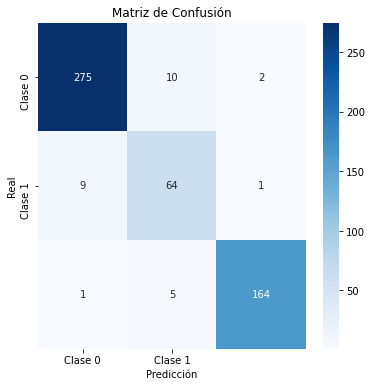


Matriz de confusión para Ramdon Forest:



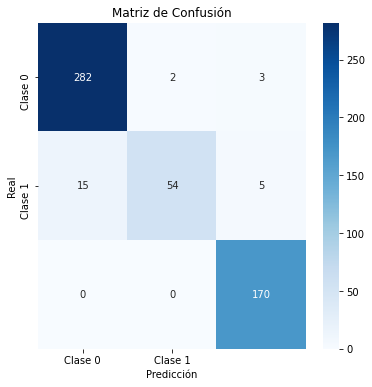


Resultados para los datos de Validate:

Exactitud de Árboles de Decisión: 0.9234488315874295
Exactitud de Random Forest: 0.9419822723609992

Informe de clasificación para Árboles de Decisión:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       672
           1       0.75      0.72      0.73       173
           2       0.97      0.94      0.96       396

    accuracy                           0.92      1241
   macro avg       0.89      0.88      0.88      1241
weighted avg       0.92      0.92      0.92      1241

Informe de clasificación para Random Forest:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       672
           1       0.91      0.66      0.77       173
           2       0.97      0.98      0.97       396

    accuracy                           0.94      1241
   macro avg       0.94      0.88      0.90      1241
weighted avg       0.94      0.94      0.94      1241

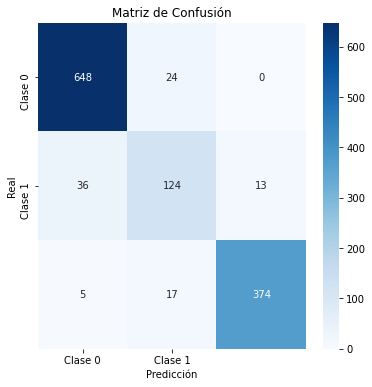


Matriz de confusión para Ramdon Forest:



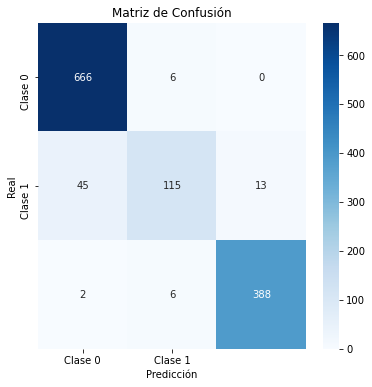

In [15]:
params = {
    'var_target': 'obesity',
    'cols_leave': ['age', 'gender_bin', 'height', 'weight', 'waist_circum_preferred', 'hip_circum'],
    'cols_encode': [],
    'cols_scale': ['age', 'height', 'weight', 'waist_circum_preferred', 'hip_circum'],
    'cols_pass': ['gender_bin'],
    'train_proportion': 0.6,
    'test_proportion': 0.5
}

test_models(df_obesity, params)


Resultados para los datos de Test:

Exactitud de Árboles de Decisión: 0.9246704331450094
Exactitud de Random Forest: 0.9397363465160076

Informe de clasificación para Árboles de Decisión:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       287
           1       0.72      0.74      0.73        74
           2       0.97      0.89      0.93       170

    accuracy                           0.92       531
   macro avg       0.88      0.87      0.88       531
weighted avg       0.93      0.92      0.92       531

Informe de clasificación para Random Forest:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       287
           1       0.80      0.76      0.78        74
           2       0.98      0.92      0.95       170

    accuracy                           0.94       531
   macro avg       0.91      0.89      0.90       531
weighted avg       0.94      0.94      0.94       531


M

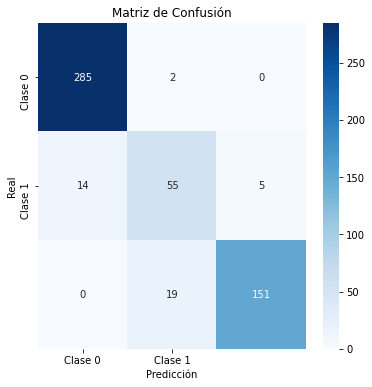


Matriz de confusión para Ramdon Forest:



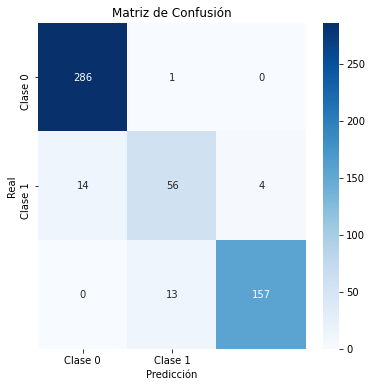


Resultados para los datos de Validate:

Exactitud de Árboles de Decisión: 0.943593875906527
Exactitud de Random Forest: 0.9468170829975826

Informe de clasificación para Árboles de Decisión:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       672
           1       0.83      0.76      0.80       173
           2       0.99      0.93      0.96       396

    accuracy                           0.94      1241
   macro avg       0.92      0.90      0.91      1241
weighted avg       0.94      0.94      0.94      1241

Informe de clasificación para Random Forest:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       672
           1       0.86      0.76      0.80       173
           2       0.99      0.94      0.96       396

    accuracy                           0.95      1241
   macro avg       0.93      0.90      0.91      1241
weighted avg       0.95      0.95      0.95      1241


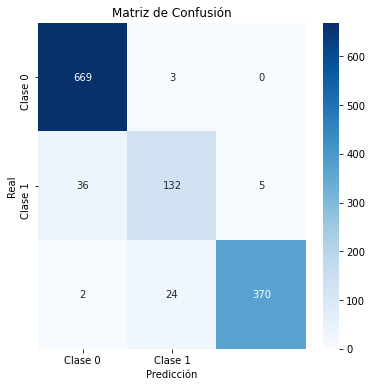


Matriz de confusión para Ramdon Forest:



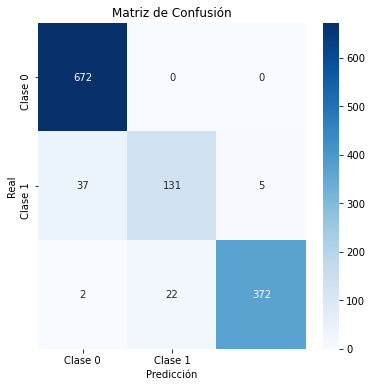

In [16]:
params = {
    'var_target': 'obesity',
    'cols_leave': ['age', 'gender_bin', 'waist_circum_preferred', 'bmi', 'rcc', 'ict'],
    'cols_encode': [],
    'cols_scale': ['age', 'waist_circum_preferred', 'bmi', 'rcc', 'ict'],
    'cols_pass': ['gender_bin'],
    'train_proportion': 0.6,
    'test_proportion': 0.5
}

test_models(df_obesity, params)


Resultados para los datos de Test:

Exactitud de Árboles de Decisión: 0.9698681732580038
Exactitud de Random Forest: 0.9698681732580038

Informe de clasificación para Árboles de Decisión:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       287
           1       0.90      0.88      0.89        74
           2       0.98      0.97      0.98       170

    accuracy                           0.97       531
   macro avg       0.95      0.95      0.95       531
weighted avg       0.97      0.97      0.97       531

Informe de clasificación para Random Forest:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       287
           1       0.91      0.86      0.89        74
           2       0.98      0.97      0.97       170

    accuracy                           0.97       531
   macro avg       0.96      0.94      0.95       531
weighted avg       0.97      0.97      0.97       531


M

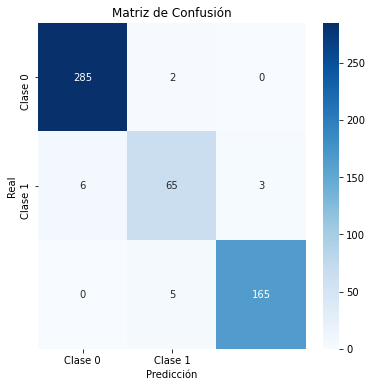


Matriz de confusión para Ramdon Forest:



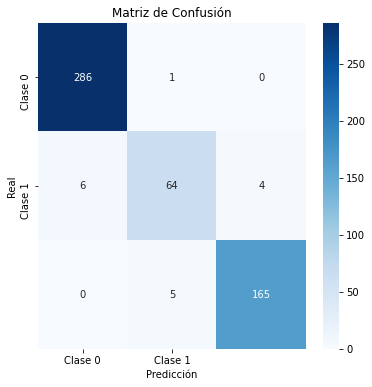


Resultados para los datos de Validate:

Exactitud de Árboles de Decisión: 0.9822723609991942
Exactitud de Random Forest: 0.9798549556809025

Informe de clasificación para Árboles de Decisión:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       672
           1       0.95      0.92      0.94       173
           2       0.99      0.98      0.99       396

    accuracy                           0.98      1241
   macro avg       0.98      0.97      0.97      1241
weighted avg       0.98      0.98      0.98      1241

Informe de clasificación para Random Forest:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       672
           1       0.96      0.90      0.93       173
           2       0.99      0.98      0.99       396

    accuracy                           0.98      1241
   macro avg       0.98      0.96      0.97      1241
weighted avg       0.98      0.98      0.98      1241

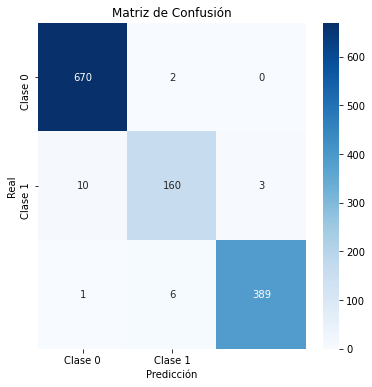


Matriz de confusión para Ramdon Forest:



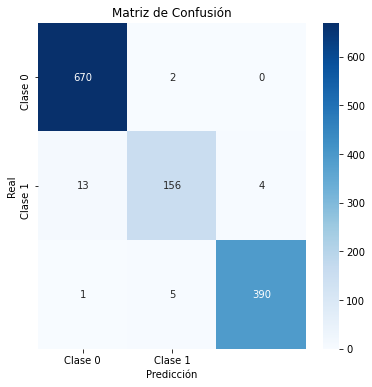

In [17]:
params = {
    'var_target': 'obesity',
    'cols_leave': ['age', 'gender_bin', 'waist_circum_preferred', 'bmi', 'rcc', 'ict'],
    'cols_encode': [],
    'cols_scale': ['age', 'waist_circum_preferred'],
    'cols_pass': ['gender_bin', 'bmi', 'rcc', 'ict'],
    'train_proportion': 0.6,
    'test_proportion': 0.5
}

test_models(df_obesity, params)


Resultados para los datos de Test:

Exactitud de Árboles de Decisión: 1.0
Exactitud de Random Forest: 1.0

Informe de clasificación para Árboles de Decisión:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       287
           1       1.00      1.00      1.00        74
           2       1.00      1.00      1.00       170

    accuracy                           1.00       531
   macro avg       1.00      1.00      1.00       531
weighted avg       1.00      1.00      1.00       531

Informe de clasificación para Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       287
           1       1.00      1.00      1.00        74
           2       1.00      1.00      1.00       170

    accuracy                           1.00       531
   macro avg       1.00      1.00      1.00       531
weighted avg       1.00      1.00      1.00       531


Matriz de confusión para Árbole

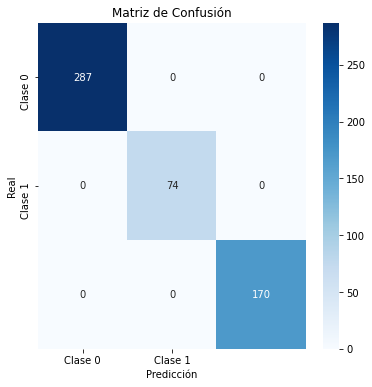


Matriz de confusión para Ramdon Forest:



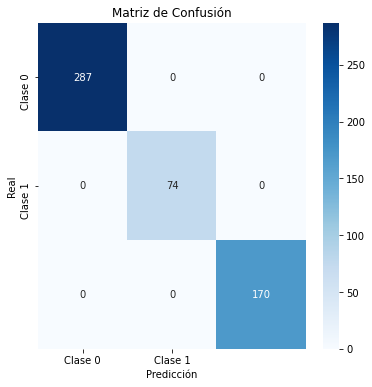


Resultados para los datos de Validate:

Exactitud de Árboles de Decisión: 0.9991941982272361
Exactitud de Random Forest: 0.9991941982272361

Informe de clasificación para Árboles de Decisión:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       672
           1       1.00      0.99      1.00       173
           2       1.00      1.00      1.00       396

    accuracy                           1.00      1241
   macro avg       1.00      1.00      1.00      1241
weighted avg       1.00      1.00      1.00      1241

Informe de clasificación para Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       672
           1       1.00      0.99      1.00       173
           2       1.00      1.00      1.00       396

    accuracy                           1.00      1241
   macro avg       1.00      1.00      1.00      1241
weighted avg       1.00      1.00      1.00      1241

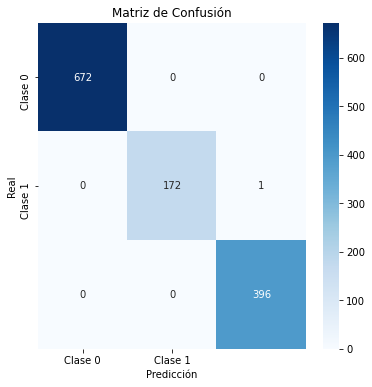


Matriz de confusión para Ramdon Forest:



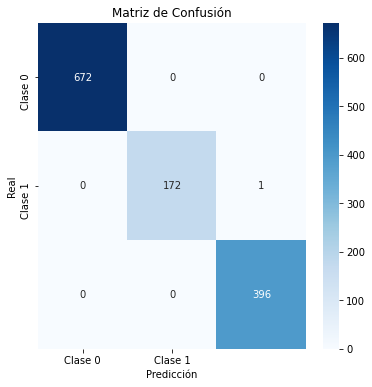

In [18]:
params = {
    'var_target': 'obesity',
    'cols_leave': ['age', 'gender_bin', 'obesity_cc', 'obesity_bmi', 'obesity_rcc', 'obesity_ict'],
    'cols_encode': [],
    'cols_scale': [],
    'cols_pass': ['age', 'gender_bin', 'obesity_cc', 'obesity_bmi', 'obesity_rcc', 'obesity_ict'],
    'train_proportion': 0.6,
    'test_proportion': 0.5
}

test_models(df_obesity, params)

## Conclusión y escogencia del modelo:

Los mejores resultados se obtienen con **Ramdon Forest** utilizando las variables:

**age, gender_bin, obesity_cc, obesity_bmi, obesity_rcc, obesity_ict**

sin ningún tipo de transformación.

## Workflow para guardar el modelo

1. Cargar los datos etiquetados
2. Seleccionar las columnas
3. Eliminar la variable objetivo
4. Transformación de los datos (aunque en este caso no se hace ninguna transformación)
5. Entrenar el modelo con todos los datos
6. Guardar el modelo


In [19]:
def save_model():
    
    CURRENT_DIR = Path.cwd()

    BASE_DIR = Path(CURRENT_DIR).parent

    df_obesity = dcf.read_file(f"{BASE_DIR}/data/out/obesity_labeled.parquet")
    
    cols_to_leave = ['age', 'gender_bin', 'obesity_cc', 'obesity_bmi', 'obesity_rcc', 'obesity_ict', 'obesity']
      
    df_train = dcf.select_data(df_obesity, [], cols_to_leave)
    
    Y_train = df_train['obesity'].copy()
    obesity_data = df_train.drop(['obesity'], axis=1)
    
    cols_encode = []
    cols_scale = []
    cols_pass = ['age', 'gender_bin', 'obesity_cc', 'obesity_bmi', 'obesity_rcc', 'obesity_ict']
    
    # Transformo los datos 
    X_train_scaled = dcf.transform_df(obesity_data, cols_encode, cols_scale, cols_pass)

    # Creo el modelo
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Entreno los modelos
    model.fit(X_train_scaled, Y_train)
    
    # save the model to a file
    with open(f"{BASE_DIR}/models/rf_obesity.pkl", "wb") as f:
        pickle.dump(model, f)
    

In [20]:
save_model()

## Workflow para hacer una predicción para una persona

Parto del principio que esto estará en una API y que se recibe y se envía un JSON:

**Entrada:** Un JSON con la siguiente información para una persona: Edad, género, peso, estatura, contorno de cintura y contorno de cadera

**Salida:** Indicadores calculados y variable **obesity**: 

**Pasos:**

1. Trasformar de JSON a dataframe
2. Calcular los indicadores
3. Seleccionar sólo las columnas que nos interesan para el modelo
4. Cargar el modelo 
5. Hacer la predicción con el modelo ya entrenado
6. Devolver el resultado




In [21]:
def make_obesity_prediction(person):

    CURRENT_DIR = Path.cwd()
    BASE_DIR = Path(CURRENT_DIR).parent
    
    df_person = pd.read_json(person, orient='records')

    df_person_transformed = custom_calculus(df_person)

    cols_to_leave = ['age', 'gender_bin', 'obesity_cc', 'obesity_bmi', 'obesity_rcc', 'obesity_ict']

    df_person_transformed = dcf.select_data(df_person_transformed, [], cols_to_leave)

    with open(f"{BASE_DIR}/models/rf_obesity.pkl", "rb") as f:
        trained_model = pickle.load(f)

    df_person['obesity'] = trained_model.predict(df_person_transformed) 

    return df_person.to_json(orient = 'records')

In [22]:
person = [{
    'age': 30,
    'gender': 'female',
    'height': 154.01,
    'weight': 51.20,
    'waist_circum_preferred': 79.0,
    'hip_circum': 96
}]

person = json.dumps(person) 

In [23]:
person = make_obesity_prediction(person)

df_person = pd.read_json(person, orient='records')

df_person

/home/diana/anaconda3/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,age,gender,height,weight,waist_circum_preferred,hip_circum,gender_bin,bmi,rcc,ict,obesity_bmi,obesity_bmi_txt,obesity_cc,obesity_cc_txt,obesity_rcc,obesity_rcc_txt,obesity_ict,obesity_ict_txt,risk_factors,obesity
0,30,female,154.01,51.2,79,96,0,21.585997,0.822917,0.512954,1,1-Normal,0,0-Bajo,1,1-Medio,2,2-Sobrepeso,2,1
